# Housing Prices: Advanced Regression Techniques

An import-to-submission notebook. __[Full project details.](https://www.kaggle.com/c/house-prices-advanced-regression-techniques)__

In [25]:
# imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet
import xgboost as XGB
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import cross_val_score
from matplotlib.finance import candlestick_ohlc
from matplotlib.lines import Line2D

## Import Data

The following code imports both the training and testing set as provided by Kaggle. As we want to do our cleaning and transforming in a uniform manor, and just once, we can merge both the training and test sets into one dataset, keeping track of which rows came from which set.

In [29]:
# read in train and test sets, save the index of the test data

df_test = pd.read_csv("/Users/marcschroeder/Dropbox/Programming/Housing Prices/test.csv",header=0,index_col='Id')
df_test_index = list(df_test.index)

df_train = pd.read_csv("/Users/marcschroeder/Dropbox/Programming/Housing Prices/train.csv",index_col='Id',header=0)

In [31]:
# create a column in both sets that identifies which set the row came from

df_test["train_or_test"] = "test"
df_train["train_or_test"] = "train"

# then concat them together
df = pd.concat([df_train,df_test])

## Handle Missing Values

Both the training and test sets had a decent amount of missing data. Not all fields are created equal in the eyes of the model. Therefore, some features would benefit from some extra attention to what we fill the missing values with.

The two features below that I'm giving extra attention are MSZoning - which could be an important indicator of the kind of building being sold, and LotFrontage. Any indicator of size should be looked over carefully as bigger properties sell for more.

The other features are less important to the model and can be filled with either "NA", 0, or values that are very common for the field.

In [4]:


#handle missing Zoning by using most common zoning for house subclass
df["MSZoning"].fillna(df["MSSubClass"].map({20:"RL",30:"RM",70:"RM"}),inplace=True)


#handle lot frontage with a simple regression based on lot area
df_area_frontage = df[["LotArea","LotFrontage"]].copy()
df_area_frontage.dropna(how="any",inplace=True)
pfit = np.polyfit(df_area_frontage["LotArea"],df_area_frontage["LotFrontage"],1)
m = pfit[0]
b = pfit[1]
df["LotFrontage"].fillna((m * df['LotArea'] + b),inplace=True)

#Handle other features using expected or N/A Values
df["Alley"].fillna("None",inplace=True)
df["Utilities"].fillna("AllPub",inplace=True)
df["Exterior1st"].fillna("VinylSd",inplace=True)
df["Exterior2nd"].fillna("VinylSd",inplace=True)
df["Exterior1st"].fillna("VinylSd",inplace=True)
df["MasVnrType"].fillna("None",inplace=True)
df["MasVnrArea"].fillna(0,inplace=True)
df["BsmtQual"].fillna("NA",inplace=True)
df["BsmtCond"].fillna("NA",inplace=True)
df["BsmtExposure"].fillna("NA",inplace=True)
df["BsmtFinType1"].fillna("NA",inplace=True)
df["BsmtFinSF1"].fillna(0,inplace=True)
df["BsmtFinType2"].fillna("NA",inplace=True)
df["BsmtFinSF2"].fillna(0,inplace=True)
df["BsmtUnfSF"].fillna(0,inplace=True)
df["TotalBsmtSF"].fillna(0,inplace=True)
df["BsmtFullBath"].fillna(0,inplace=True)
df["BsmtHalfBath"].fillna(0,inplace=True)
df["KitchenQual"].fillna("TA",inplace=True)
df["Functional"].fillna("Typ",inplace=True)
df["FireplaceQu"].fillna("Typ",inplace=True)
df["GarageType"].fillna("NA",inplace=True)
df['GarageYrBlt'].fillna(df['YearBuilt'],inplace=True)
df["GarageFinish"].fillna("NA",inplace=True)
df["GarageCars"].fillna(0,inplace=True)
df["GarageArea"].fillna(0,inplace=True)
df["GarageQual"].fillna("NA",inplace=True)
df["GarageCond"].fillna("NA",inplace=True)
df["GarageCond"].fillna("NA",inplace=True)
df["PoolQC"].fillna("NA",inplace=True)
df["Fence"].fillna("NA",inplace=True)
df["MiscFeature"].fillna("NA",inplace=True)
df["SaleType"].fillna("WD",inplace=True)

## Exploratory Data Analysis

Before making a machine learning model to make predictions, let's get to know our dataset better.

#### Neighborhood Profile

One of the biggest predictors of price could be the neighborhood the property is located in. First, let's take a look at the zoning breakdown of all neighborhoods.

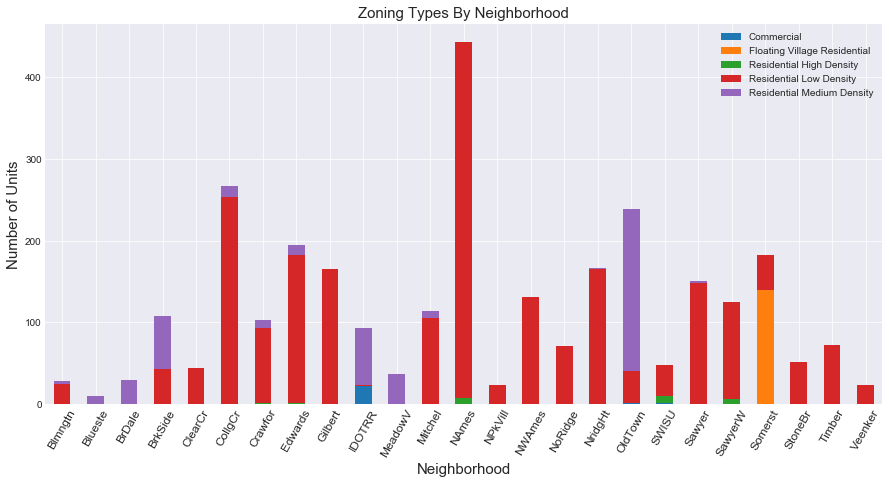

In [5]:
# select Neighborhood and MSZoning columnns as new dataframe
zones_by_neighborhood = df.groupby(['Neighborhood','MSZoning']).MSSubClass.count()

# unstack multiindex to create column for each zoning type per neighborhood
zones_by_neighborhood = zones_by_neighborhood.unstack()

# fill missing values with 0s
zones_by_neighborhood.fillna(0,inplace=True)

# rename columns for legend
zones_by_neighborhood.columns = ["Commercial",
                                 "Floating Village Residential",
                                 "Residential High Density",
                                 "Residential Low Density",
                                 "Residential Medium Density"]

# plot and format
sns.set_style('darkgrid')
zones_by_neighborhood.plot.bar(stacked=True,figsize=(15,7))
plt.title("Zoning Types By Neighborhood",size=15)
plt.xticks(rotation=60,size=12)
plt.ylabel("Number of Units",size=15)
plt.xlabel("Neighborhood",size=15)
plt.legend()
plt.show()

#### Average Cost of Neighborhood

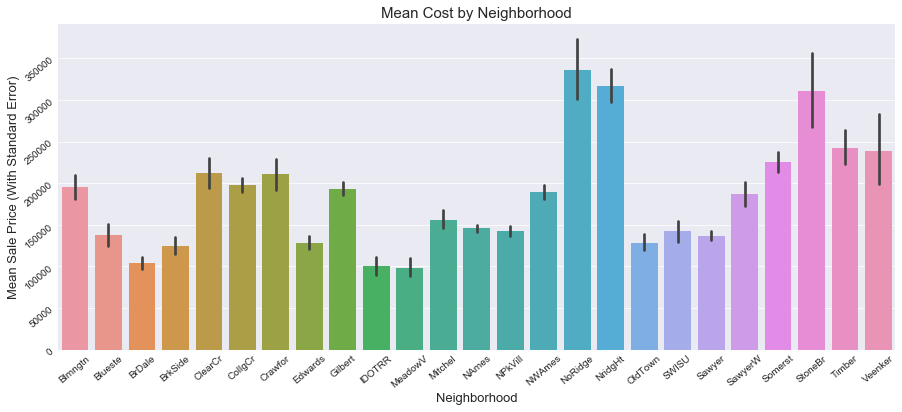

In [6]:
df_train = pd.read_csv("/Users/marcschroeder/Dropbox/Programming/Housing Prices/train.csv",index_col='Id',header=0)
df_neighborhood_prices = df_train[["Neighborhood",'SalePrice']].copy()

alpha_names = sorted(df["Neighborhood"].unique())

sns.set_style('darkgrid')
plt.figure(figsize=(15,6))
sns.barplot(data=df_neighborhood_prices,
            order = alpha_names,
            x="Neighborhood",
            y="SalePrice",)
plt.tick_params(rotation=40)
plt.title("Mean Cost by Neighborhood",fontsize=15)
plt.ylabel("Mean Sale Price (With Standard Error)",fontsize = 13)
plt.xlabel("Neighborhood",fontsize = 13)
plt.show()

#### Numeric Feature Correlation to SalePrice

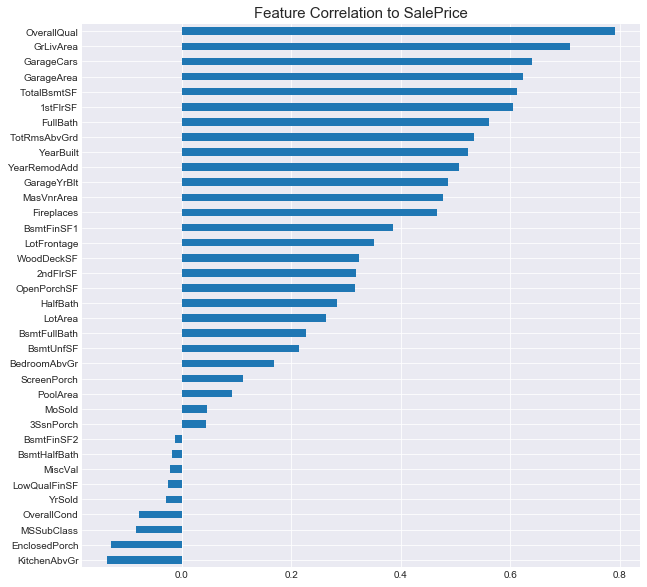

In [7]:
df_saleprice_corr = df_train.corr().SalePrice.drop("SalePrice")
df_saleprice_corr = df_saleprice_corr.sort_values(ascending=True)

plt.figure(figsize=(10,10))
plt.title("Feature Correlation to SalePrice",size=15)
df_saleprice_corr.plot(kind='barh')
plt.show()

## Create Lists of Data Types

This dataset contains three different kinds of fields.

-  Numeric fields with continuous values
-  Labeled fields with unordered values
-  Labeled feilds with ordered values (Ordinal)

Each of these should be handled differently for the model to both be able to use them and get maximum value out of the information.

The first step is to store the feature names as lists according to their type.

In [8]:
#sort column by feature type

NUMERIC = []
LABELED = []
ORDINAL = ['LotShape','Utilities',"LandSlope","OverallQual","OverallCond","ExterQual",
           'ExterCond','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','HeatingQC',
          "KitchenQual",'Functional',"FireplaceQu",'GarageFinish','GarageQual','GarageCond',
          'PavedDrive','PoolQC','Fence']

for i in range(0,len(df.columns)):
    if df.columns[i] not in ORDINAL:
        if df.iloc[:,i].dtype == 'object':
            LABELED.append(df.columns[i])
        else:
            NUMERIC.append(df.columns[i])
            
        
#MSSSubclass is a category marked with numbers
NUMERIC.remove("MSSubClass")
LABELED.append("MSSubClass")

LABELED.remove("train_or_test")

## Handle Labeled Data

As labeled data has no order, we can simply use the Pandas get_dummies function to create binary columns for each feature. We will store the result of this function in a new dataframe.

In [9]:
# convert types to strings
df[LABELED] = df[LABELED].astype(str)

# use get_dummies function to create new df with binary encoded values
df_labeled_encoded = pd.get_dummies(df[LABELED])

## Handle Ordinal Data

There are quite a few ways to encoder ordinal data. Pandas provides a way to convert these fields to ordered categories, and then turn those categories into numeric values.

I also found an open source __[library](https://github.com/scikit-learn-contrib/categorical-encoding)__ on GitHub that offers several different methods of encoding ordinal features. I tested the outcomes using each encoder class and selected the highest performing class. We will store the transformed dataset in a new dataframe.

#### Method 1: Use Dictionary of Ordered Categories and Convert

In [10]:
# # handle ordinal data
# df_ordinals_coded = pd.DataFrame()

# lookup = {"LotShape" : ["Reg","IR1","IR2","IR3"],
# "Utilities" : ["AllPub","NoSewr","NoSeWa","ELO"],
# "LandSlope" : ["Gtl","Mod","Sev"],
# "OverallQual" : [10,9,8,7,6,5,4,3,2,1],
# "OverallCond" : [10,9,8,7,6,5,4,3,2,1],
# "ExterQual" : ["Ex","Gd","TA","Fa","Po"],
# "ExterCond" : ["Ex","Gd","TA","Fa","Po"],
# "BsmtQual" : ["Ex","Gd","TA","Fa","Po","NA"],
# "BsmtExposure" : ["Gd","Av","Mn","No","NA"],
# "BsmtFinType1" : ["GLQ","ALQ","BLQ","Rec","LwQ","Unf","NA"],
# "BsmtFinType2" : ["GLQ","ALQ","BLQ","Rec","LwQ","Unf","NA"],
# "HeatingQC" : ["Ex","Gd","TA","Fa","Po"],
# "KitchenQual" : ["Ex","Gd","TA","Fa","Po"],
# "Functional" : ["Typ","Min1","Min2","Mod","Maj1","Maj2","Sev","Sal"],
# "FireplaceQu" : ["Ex","Gd","TA","Typ","Fa","Po","NA"],
# "GarageFinish" : ["Fin","RFn","Unf","NA"],
# "GarageQual" : ["Ex","Gd","TA","Fa","Po","NA"],
# "GarageCond" : ["Ex","Gd","TA","Fa","Po","NA"],
# "PavedDrive" : ["Y","P","N"],
# "PoolQC" : ["Ex","Gd","TA","Fa","NA"],
# "BsmtCond" :["Ex","Gd","TA","Fa","Po","NA"],
# "Fence" : ["GdPrv","MnPrv","GdWo","MnWw","NA"]}

# df[ORDINAL] = df[ORDINAL].fillna("NA")


# for c in ORDINAL:

#     sort_values_list = sorted(df[c].unique(),key=lambda x: lookup[c].index(x))
#     df_ordinals_coded[c] = df[c].astype('category')
#     df_ordinals_coded[c] = df_ordinals_coded[c].cat.reorder_categories(sort_values_list,ordered=True)
#     df_ordinals_coded[c] = df_ordinals_coded[c].cat.codes
    

#### Method 2: Use Best Encoder Class From category_encoders Package

Note: Via a manual test, ce.OneHotEncoder() proved to be the highest-performing encoder class.

In [11]:
# handle ordinal data
import category_encoders as ce

# select encoder class

# encoder = ce.BackwardDifferenceEncoder()
# encoder = ce.BinaryEncoder()
# encoder = ce.HashingEncoder()
# encoder = ce.HelmertEncoder()
encoder = ce.OneHotEncoder()
# encoder = ce.OrdinalEncoder()
# encoder = ce.SumEncoder()
# encoder = ce.PolynomialEncoder()

# fill any missing values
df[ORDINAL] = df[ORDINAL].fillna("NA")

# use the encoder class to convert ordinals
df_ordinals_coded = encoder.fit_transform(df[ORDINAL])



## Remove Skew From Numeric Features Using np.log1p()

Machine learning algorithms work better on unskewed numerical features (i.e. features with close to normal distributions). A standard practice is to use Numpy's log1p() function to transform the data in the feature to have more of a normal distribution. An advantage of using this particular function is that an easily applicable inverse function is also available via Numpy, expm1(). In order to preserve scale, the target varable will need to be transformed using this function as well. The final model output will be untransformed for a final prediction of building price.

Like the other two feature types, will store the transformed dataset in another new dataframe.

First, let's compute the absolute value of the skew of the numeric features, and visualize it.

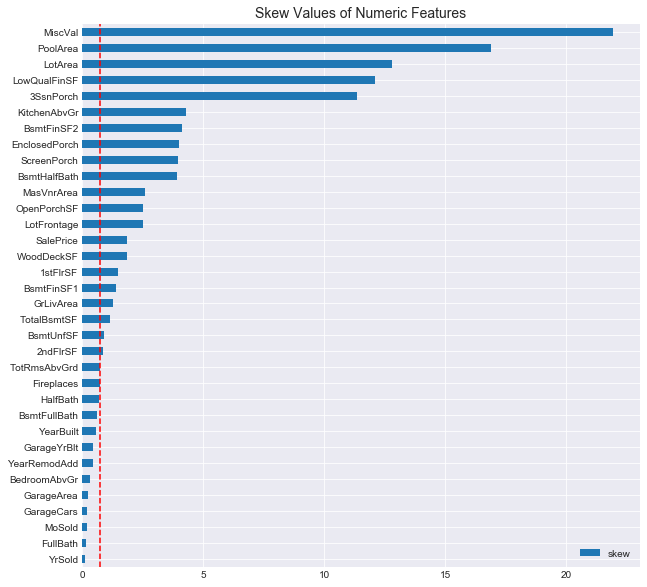

In [12]:
#examine skew in numeric data.
from scipy.stats import skew

# get abs skew values for all numeric columns
df_numeric_skew = df[NUMERIC].apply(lambda x: np.abs(skew(x.dropna())))
df_numeric_skew = df_numeric_skew.sort_values().to_frame()
df_numeric_skew.columns = ["skew"]


# plot and format
_ = df_numeric_skew.plot(kind='barh',figsize=(10,10))
_ = plt.plot([.75,.75],[-1,35],
            color="red",
            linestyle="--")
plt.title("Skew Values of Numeric Features",size=14)
plt.show()

Below, we will select the features with skews higher than 0.75 (denoted by the red line in on the chart above), and apply np.log1p() to them.

In [13]:
# get columns with a high skew value
df_numeric_high_skew = df_numeric_skew[df_numeric_skew > 0.75].dropna()

# save high skew columns as a list
HIGH_SKEW = list(df_numeric_high_skew.index)

print len(HIGH_SKEW)

# modify the high skew values in the orginal dataframe
df[HIGH_SKEW] = df[HIGH_SKEW].apply(np.log1p,axis=1)

22


## Bring All Feature Types Back Together

Now that all three feature types have been transformed, we can bring the three transformed dataframes together, along with the column from the orginal dataframe denoting which set the row came from.

In [14]:
df_all_features = pd.concat([df[NUMERIC],df_labeled_encoded,df_ordinals_coded,df["train_or_test"]],axis=1)

## Split Train and Test Datasets

Using the denoation column, we can split our now-transformed train and test sets back into seperate dataframes. We can also drop the SalePrice column from the test set. Printing the shapes of each dataframe at this stage acts as a sanity-check.

In [15]:
print df_all_features.shape

# sort back into new dataframes using train_or_test column
df_train = df_all_features[df_all_features["train_or_test"] == "train"].copy()
df_test = df_all_features[df_all_features["train_or_test"] == "test"].copy()

# drop train_or_test column from new dataframes, and saleprice from test
df_train.drop("train_or_test",axis=1,inplace=True)
df_test.drop("train_or_test",axis=1,inplace=True)
df_test.drop("SalePrice",axis=1,inplace=True)

#sanity check
print df_train.shape
print df_test.shape

(2919, 340)
(1460, 339)
(1459, 338)


## Create Training Varables and Fit to XGBoost Model

Via testing, XGBoost was found to be the most performant model. It's hyper parameters were tuned using a GridSearchCV. Here, we train it on the transformed training data.

In [16]:
y = df_train['SalePrice'].values
X = df_train.drop('SalePrice',axis=1).values
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=23)


xgb = XGBRegressor(learning_rate=0.05,n_estimators=700,max_depth=3,colsample_bytree=0.2)

xgb.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.2, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=700,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

## Test Model on Training Set to Preview Score

As a good estimate of how the model will perform on unseen data. We can use the traing set to score the model before submitting. Below we will take a look at the default score paramter from xgboost, as well as the root mean squared error and the root mean squared log error (the actual scoring parameter) for both the transformed and untransformed set. As a futher measure of accuracy, we do a 10-fold cross validation to get a better idea of the models performance on unseen data.

In [17]:
from sklearn.metrics import mean_squared_error


y_pred = xgb.predict(X_test)

print "XGBoost Score: " + xgb.score(X_test,y_test).astype(str)
print "RMSE: " + np.sqrt(mean_squared_error((y_test),
                                            (y_pred))).astype(str)
print "RMSLE: " + np.sqrt(mean_squared_error(np.log(y_test),
                                             np.log(y_pred))).astype(str)

y_test_untransformed = np.expm1(y_test)
y_pred_untransformed = np.expm1(y_pred)
print "RMSE (Untransformed): " + np.sqrt(mean_squared_error((y_test_untransformed),
                                                          (y_pred_untransformed))).astype(str)
print "RMSLE (Untransformed): " + np.sqrt(mean_squared_error(np.log(y_test_untransformed),
                                                           np.log(y_pred_untransformed))).astype(str)

cvscores_10 = cross_val_score(xgb,X,y,cv=10)
print "CV Score Mean: " + (np.mean(cvscores_10)).astype(str)

XGBoost Score: 0.909644061431
RMSE: 0.118104211304
RMSLE: 0.0101405803772
RMSE (Untransformed): 18464.3923269
RMSLE (Untransformed): 0.118105346087
CV Score Mean: 0.915330115222


## Examine Feature Importances As Deturmined by XGBoost

Once trained, the model can tell us what features it found most important predictors of the target varable.

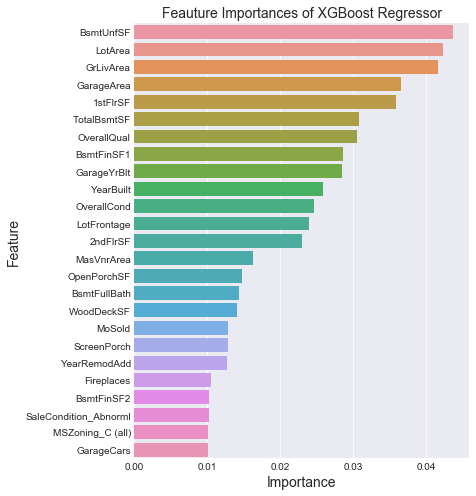

In [18]:
names = df_train.drop("SalePrice",axis=1).columns

df_feature_importances = pd.DataFrame({"feature":names,"importance":xgb.feature_importances_})
df_feature_importances.sort_values("importance",ascending=False,inplace=True)
df_feature_importances = df_feature_importances.head(25)

plt.figure(figsize=(6,8))
sns.barplot(x=df_feature_importances.importance,
            y=df_feature_importances.feature)
plt.title("Feauture Importances of XGBoost Regressor", size=14)
plt.xlabel("Importance",size=14)
plt.ylabel("Feature",size=14)
plt.show()

Similar to the graph above on overall correaltion, the most highest importance features are mostly the indicators of overall size such as the lot area, living area above ground, and number of cars in the garage. Simply put, bigger houses cost more. Other categorical or ordinal variables made it into the top 25 most important features such as the overall condition of the house, if the "sale condition" was abnormal or not, or if it was a commercial building.

## Visualizing Model Performance

In addition to the above metrics, I've created a function to create a visualization that borrows from the idea of candlestick charts used in finance to visualize the difference in the real house value compared to the value predicted by the model. The function is written to be resuable and could be used on any regression problem.

In [19]:
def make_results_candles(ytest,ypred):
    
    # if not already imported: 
    # from matplotlib.finance import candlestick_ohlc
    # from matplotlib.lines import Line2D
    
    # create dataframe from passed values
    df_results = pd.DataFrame({"real":ytest,"predicted":ypred})

    # sort by real price and reset index to add a range of values for x axis
    df_results = df_results.sort_values('real')
    df_results = df_results.reset_index()
    df_results.drop('index',axis=1,inplace=True)
    df_results = df_results.reset_index()

    # for each row in dataframe, compile a sublist in format needed for candlestick plot
    list_of_results = []
    for index,row in df_results.iterrows():
        values = [row['index'],row['real'],row['predicted'],row['real'],row['predicted']]
        list_of_results.append(values)
    
    # create dummy lines for legend
    custom_lines = [Line2D([0], [0], color='black', lw=4),
                    Line2D([0], [0], color='red', lw=4)]
    
    # plot and format
    fig = plt.figure(figsize=(16,8))
    ax1 = plt.subplot2grid((6,1), (0,0), rowspan=6, colspan=1)
    ax1.legend(custom_lines,
               ["Model Overvalued Real Value","Model Undervalued Real Value"])
    plt.xticks(size=0)
    plt.xlabel(" --- Real Values Increase --->",size=15)
    plt.yticks(size=12)
    plt.title("Deltas of Real and Predicted Values",size=15)
    candlestick_ohlc(ax1,list_of_results)
    plt.show()

In this case, we will drop in the untransformed values of y_test (the real values from the above train_test_split), and y_pred (values outputted by xgboost model)

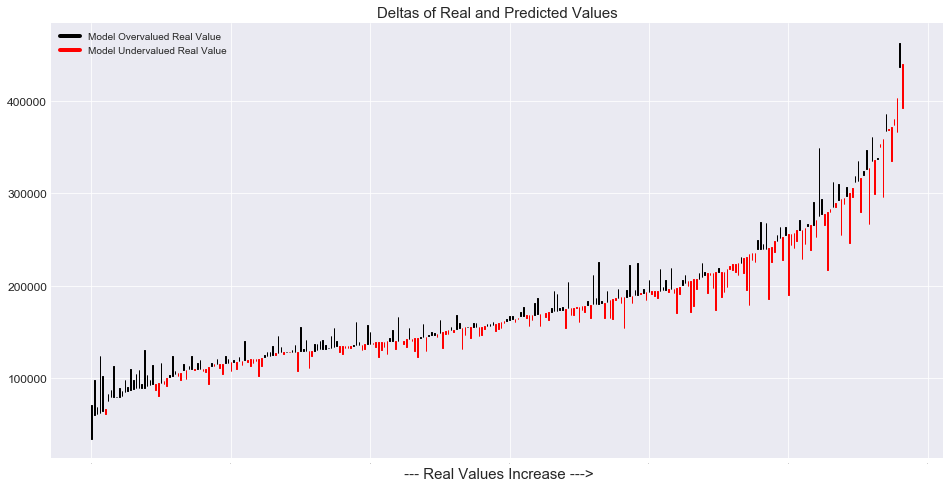

In [20]:
make_results_candles(y_test_untransformed,y_pred_untransformed)

This graph tells us a few things. With this test set, the model is at its most accurate in the middle of the price range. As the values tend to increase, it appears to be more likely the model will undervalue the price. Conversely, the model appears to be more prone to overvaluation in the lower price range.

## Train Model On Full Set Of Training Data

In [21]:
y = df_train['SalePrice'].values
X = df_train.drop('SalePrice',axis=1).values

xgb = XGBRegressor(learning_rate=0.05,n_estimators=700,max_depth=3,colsample_bytree=0.2)

xgb.fit(X,y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.2, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=700,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

## Create Competition Prediction From Model and Untransform

Using the trained XGBoost model, we can make predictions on the log+1 transformed SalePrice. To get our final predictions, we will untransform those predictions using the inverse function.

In [22]:
X_test = df_test.values

y_pred = xgb.predict(X_test)

untransformed_predictions = np.expm1(y_pred)

## Create Dataframe From Predictions and Write to CSV

The last step is to create a CSV for submission using the predictions genreated above.

In [23]:
# Create dataframe from predictions
df_submission_csv = pd.DataFrame({"Id":df_test_index,"SalePrice":untransformed_predictions})
df_submission_csv.set_index("Id",inplace=True)

# write to CSV
df_submission_csv.to_csv("submission.csv")

## Results

Training the XGBoost model on this dataset yeilds a competition root mean squared log error of 0.12343, enough to make it into the top 30% of all 3000+ submissions.

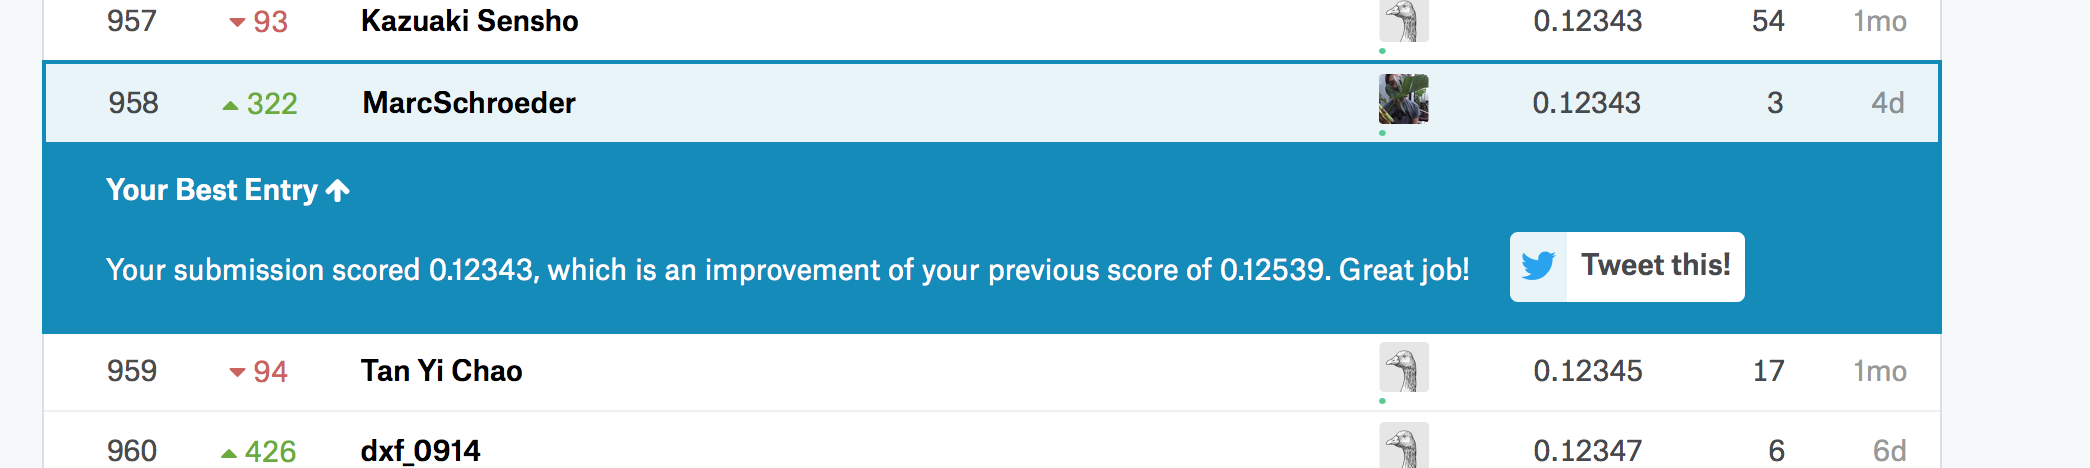